In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

from sklearn import preprocessing

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

## Statistical Analysis helper functions

In [2]:
# Get Basic Column Statistics values - max, min, count, average, standard deviation, first, last

def get_col_count(df, col): return df[col].count()
def get_col_min(df, col):   return df[col].min()
def get_col_max(df, col):   return df[col].max()
def get_col_avg(df, col):   return df[col].mean()
def get_first(df):          return df.iloc[0]
def get_last(df):           return df.iloc[-1]
def get_col_std(df, col):   return df[col].std()

In [3]:
# Correlation matrix (only triangle)
def get_df_correlation(df, figure_size=(11, 9)):

    corr = df.corr()
    plt.subplots(figsize=figure_size)

    cmap = sns.diverging_palette(220, 20, as_cmap=True) # custom colormap https://seaborn.pydata.org/tutorial/color_palettes.html

    triangle = np.zeros_like(corr, dtype=np.bool)
    triangle[np.triu_indices_from(triangle)] = True
    ax = sns.heatmap(corr, mask=triangle, cmap=cmap, center=0, square=True, linewidths=.15, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

## Generalized Plot-related Functions

In [4]:
# Bar plot for the chosen column of the provided dataframe
def bar_plot(df, col):
    feature_count = "{}_count".format(col)
    
    grouped_df = df.groupby([col])
    aggregation = grouped_df.agg({col: ['count']}).reset_index()
    aggregation.columns = [col, feature_count]
    sns.barplot(x = aggregation[col], y = aggregation[feature_count], palette="magma")
    plt.show()
    
# Scatter plot for 2 chosen columns of the provided dataframe
def scatter_plot_two_cols(df, x_col, y_col, figure_size=(12, 9)):
    
    # Size of plot
    plt.subplots(figsize=figure_size)
    
    # Generate a custom diverging colormap https://seaborn.pydata.org/tutorial/color_palettes.html
    cmap = sns.diverging_palette(220, 20, as_cmap=True) 

    sns.scatterplot(data=df, x=x_col, y=y_col, hue='status',palette=cmap, sizes=(47,47))
    plt.show()

# Bubble plot for 3 chosen columns of the provided dataframe
def bubble_plot_three_cols(df, x_col, y_col, hue_size_col):
    
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_size_col, size=hue_size_col, palette=cmap, sizes=(50, 300))

    plt.show()


## Encoding/atributes' type-related helper functions

In [5]:
# Convert date (seen as type object) to datetime
def convert_date(df, column, format_='%y%m%d'):
    df_ = df.copy() # copy dataframe to avoid making changes to it inside the function
    df_[column] = pd.to_datetime(df_[column], format=format_)
    return df_

# Encode column of dataframe
def encode_column(df, column_to_encode):
    
    df_ = df.copy() # copy dataframe to avoid making changes to it inside the function
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df_[column_to_encode].unique())
    df_[column_to_encode] = label_encoder.transform(df_[column_to_encode])
    
    return df_

## Missing Values

In [6]:
# Missing Values summary of provided dataset
def missing_values(dataset):
    print(dataset.isnull().mean())

In [7]:
# Missing Values Cleaning
def missing_values_cleaning(df):
    
    # Drop columns and rows with missing value percentage > 0.7
    df = df[ df.columns[ df.isnull().mean() < 0.7 ] ]
    df = df.loc[ df.isnull().mean(axis = 1) < 0.7 ]
    
    return df

In [8]:
# Missing Values Treatment: for numerical columns, replace with custom value or median 
def clean_numerical_missing_values(dataset, replacer=None):

    dataset = dataset.fillna(replacer if replacer is not None else dataset.median())
    return dataset

# Missing Values Treatment: for categorical columns, replace with custom value or max value (that isn't null)
def clean_categorical_missing_values(dataset, col, replacer=None):

    dataset[col].fillna(replacer if replacer is not None else dataset[col].value_counts().idxmax(), inplace=True)
    
    return dataset

# Feature Selection Algorithms

## Filter Method - Correlation Threshold

In [9]:
filter_features = []

# Apply to train (only!)
def select_features_filtering(original_df):

    original_corr = original_df.corr()
    
    # gets only last row (only one that really matters here)
    # and drops status col (not useful for correlation with itself)
    status_corr = original_corr.tail(1).drop(['status'], axis = 1)

    print('Correlations with label:')
    display(status_corr)
    
    # ':' means it applies to every row
    status_corr = status_corr.loc[:, ( abs(status_corr) > 0.15 ).any()]

    # print('Features that made it:')
    # display(status_corr)

    for col in status_corr: filter_features.append(col)

## Wrapper Method - Logistic Regression
#### Parameters: max_iter=1000, k_features='best', forward=True, floating=False,verbose=2, scoring='roc_auc', n_jobs=-1, cv=0

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression as LGR

In [11]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

wrapper_features = []

def analyse_sfs(sfs1):
    display(sfs1.subsets_)
    print('-----')
    display(sfs1.get_metric_dict())
    print('-----')
    
    fig1 = plot_sfs(sfs1.get_metric_dict(confidence_interval=0.95), kind='std_err')
    plt.title('Sequential Forward Selection')
    plt.grid()
    plt.show()
    
    print("-------------------------")

    display(sfs1.k_feature_names_, sfs1.k_feature_idx_)

    print("-------------------------")
    
    dfy_ = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
    dfy_[["feature_idx", "avg_score"]]
    wrapper_features = dfy_[["feature_idx"]]

In [12]:
def select_features_wrapper(origin_df):
    
    features = origin_df.drop(['loan_id', 'status'], axis=1).select_dtypes(include=np.number).columns
    
    X = origin_df.drop(['loan_id', 'status'], axis=1).select_dtypes(include=np.number)
    y = origin_df['status']
    
    print("X columns:")
    print(X.dtypes)
    print("Y:")
    print(y)
    print()
    
    # Only run in train
    sfs1 = SFS(LGR(max_iter=1000),
               k_features='best',
               forward=True,
               floating=False,
               verbose=2,
               scoring='roc_auc', #roc_auc #accuracy
               n_jobs=-1,
               cv=0)
    
    sfs1 = sfs1.fit(X, y, custom_feature_names=features)
    
    analyse_sfs(sfs1)

## Load data

In [13]:
# Loading tables
account_df = pd.read_csv('./raw/account.csv', delimiter=";")
disp_df = pd.read_csv('./raw/disp.csv', delimiter=';')
client_df = pd.read_csv('./raw/client.csv', delimiter=';')
district_df = pd.read_csv('./raw/district.csv', delimiter=';')
trans_df = pd.read_csv('./raw/trans_dev.csv', delimiter=';')
loan_df = pd.read_csv('./raw/loan_dev.csv', delimiter=';')
card_df = pd.read_csv('./raw/card_dev.csv', delimiter=';')
card_test_df = pd.concat([pd.read_csv('./raw/card_comp.csv', delimiter=';'), card_df])
trans_test_df = pd.concat([pd.read_csv('./raw/trans_comp.csv', delimiter=';'), trans_df])
loan_test_df = pd.read_csv('./raw/loan_comp.csv', delimiter=';')

# display(account_df.head())
# display(trans_df.head())

# Individual tables

No past history regarding loans.
There is an obvious and expected correlation between the duration, amount and payments columns.


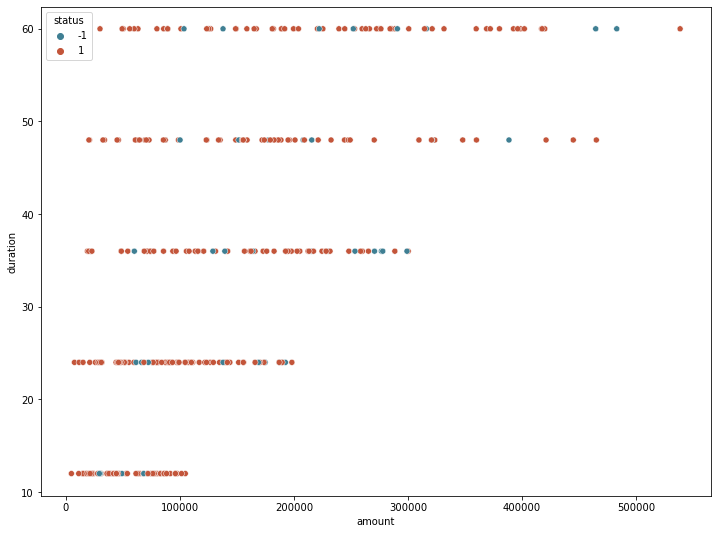

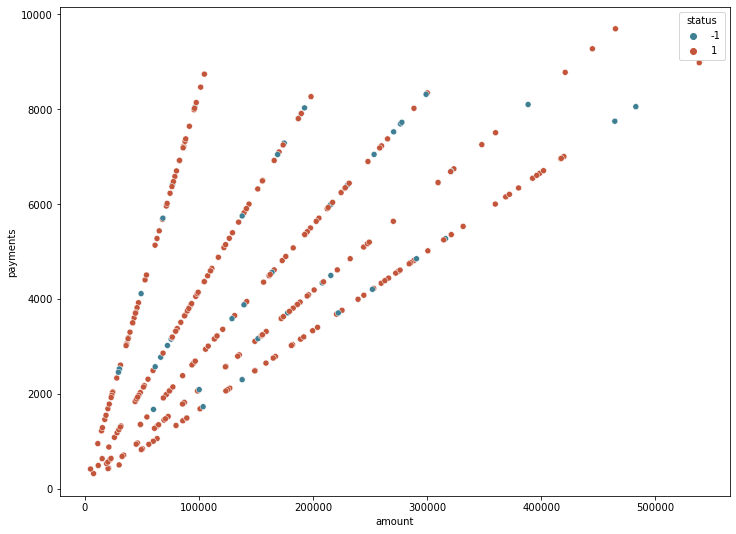

As expected, the larger the amount, the larger is the monthly payment or the duration.
Does the bank charge any interest rate?


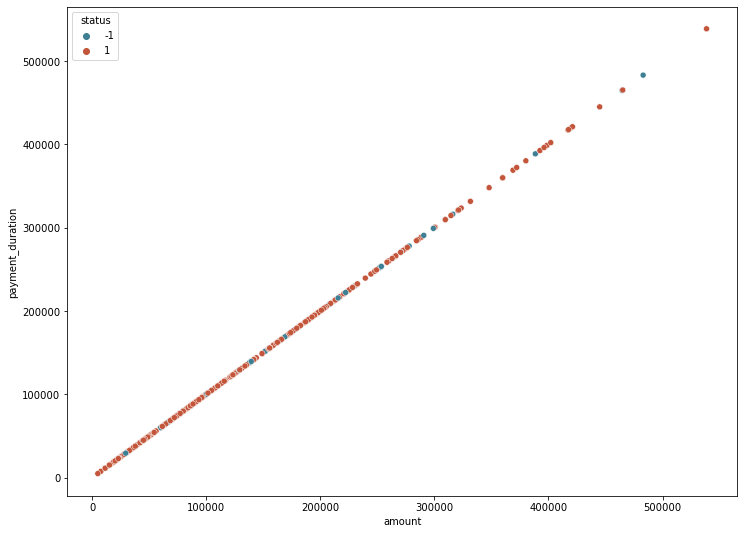

amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan


loan_id  account_id       date  amount  duration  payments  status
0       5314        1787 1993-07-05   96396        12      8033      -1
1       5316        1801 1993-07-11  165960        36      4610       1
2       6863        9188 1993-07-28  127080        60      2118       1
3       5325        1843 1993-08-03  105804        36      2939       1
4       7240       11013 1993-09-06  274740        60      4579       1
..       ...         ...        ...     ...       ...       ...     ...
323     6818        9030 1996-12-12  155616        48      3242       1
324     5625        3189 1996-12-15  222180        60      3703      -1
325     6805        8972 1996-12-21   45024        48       938       1
326     7233       10963 1996-12-25  115812        36      3217       1
327     7308       11362 1996-12-27  129408        24      5392       1

[328 rows x 7 columns]

In [14]:
def process_loans(loans_df):
        
    processed_df = convert_date(loans_df, 'date')
    
    print('No past history regarding loans.\nThere is an obvious and expected correlation between the duration, amount and payments columns.')
    scatter_plot_two_cols(processed_df, 'amount', 'duration'); scatter_plot_two_cols(processed_df, 'amount', 'payments')
    print('As expected, the larger the amount, the larger is the monthly payment or the duration.')

    print('Does the bank charge any interest rate?')
    processed_df['payment_duration'] = processed_df['duration'] * processed_df['payments']
    scatter_plot_two_cols(processed_df, 'amount', 'payment_duration')

    processed_df = processed_df.drop(['payment_duration'], axis=1)

    print('amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan')
        
    return processed_df

process_loans(loan_df)

In [15]:
def process_account(accounts_df):
    processed_account = convert_date(account_df, 'date')
    return encode_column(processed_account, 'frequency') # Encode freq

processed_account = process_account(account_df)

Transformed the categorical type column into numerical respective columns


disp_id  client_id  account_id  type_O  type_U
0           1          1           1       1       0
1           2          2           2       1       0
2           3          3           2       0       1
3           4          4           3       1       0
4           5          5           3       0       1
...       ...        ...         ...     ...     ...
5364    13647      13955       11349       1       0
5365    13648      13956       11349       0       1
5366    13660      13968       11359       1       0
5367    13663      13971       11362       1       0
5368    13690      13998       11382       1       0

[5369 rows x 5 columns]

2 categories are dependent. Therefore, remove one - removing redundancy


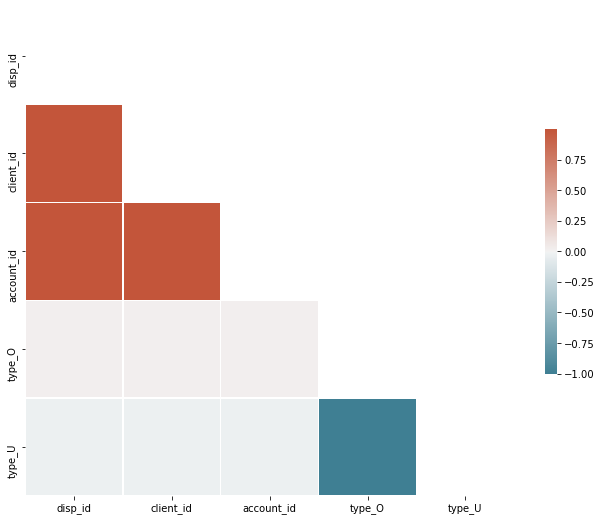

In [16]:
def process_disp(disp_df):   
    processed_disp = disp_df.copy()
    
    # Renaming disp attributes
    processed_disp.loc[processed_disp["type"] == "OWNER",    "type"] = "O"
    processed_disp.loc[processed_disp["type"] == "DISPONENT","type"] = "U"
    
    # Transform numerical into categorical
    df = pd.get_dummies(processed_disp)
    
    print('Transformed the categorical type column into numerical respective columns')
    display(df)
    print('2 categories are dependent. Therefore, remove one - removing redundancy')
    get_df_correlation(df)
        
    return df

processed_disp = process_disp(disp_df)

In [17]:
def process_card(card_df):
    processed_card = convert_date(card_df, 'issued')
    # bar_plot(processed_card, 'type')
    return encode_column(processed_card, 'type').drop(['card_id'], axis=1)

processed_card = process_card(card_df)

In [18]:
def process_client(client_df):
    # print(client_df.head())
    # get_df_correlation(client_df)
    df_copy = client_df.copy()
    
    # Parsing birth_number into year, month, day and gender
    df_copy['year'] = 1900 + (df_copy['birth_number'] // 10000)
    df_copy['day'] = df_copy['birth_number'] % 100
    df_copy['mth_sex'] = (df_copy['birth_number'] % 10000) // 100
    df_copy['gender'] = np.where(df_copy['mth_sex']>=50, 1, 0)
    df_copy['month'] = np.where(df_copy['mth_sex']>=50, df_copy['mth_sex']-50, df_copy['mth_sex'])

    # Building date
    df_copy['birth_date'] = df_copy['year'] * 10000 + df_copy['month'] * 100 + df_copy['day']
    df = convert_date(df_copy, 'birth_date', '%Y%m%d')
    
    # Drop now useless columns
    df = df.drop(['birth_number', 'year', 'mth_sex', 'month', 'day'], axis=1)
    
    # print('1 = female\t\t 0 = male')
    # display(df)
    # get_df_correlation(df)
    
    return df

processed_client = process_client(client_df)

In [19]:
def process_transactions(transactions_df):

    # display(transactions_df)
    # get_df_correlation(transactions_df)
    # missing_values(transactions_df)
        
    # Removing the null columns & processing data
    transact_df = missing_values_cleaning(transactions_df)
    transact_df = clean_categorical_missing_values(transact_df, 'k_symbol', ' ')
    transact_df = convert_date(transact_df, 'date')
    
    # print('Type of trans k_symbol:')
    # display(transact_df['k_symbol'].unique())
    
    transact_df.loc[ transact_df["type"]      == "withdrawal in cash", "type"]                = "withdrawal" # 'withdrawal in cash' -> 'withdrawal'
    transact_df.loc[ transact_df["operation"] == "credit in cash",               "operation"] = "credit_cash"
    transact_df.loc[ transact_df["operation"] == "collection from another bank", "operation"] = "col_another_bank"
    transact_df.loc[ transact_df["operation"] == "withdrawal in cash",           "operation"] = "withd_cash"
    transact_df.loc[ transact_df["operation"] == "remittance to another bank",   "operation"] = "rem_another_bank"
    transact_df.loc[ transact_df["operation"] == "credit card withdrawal",       "operation"] = "credit_card_withd"
    transact_df = clean_categorical_missing_values(transact_df, 'operation', 'interest')      # Interest credited

    transact_df.loc[transact_df["type"] == "withdrawal", "amount"] *= -1 # Withdraw taken as negative 
    
    # Aggregatting transaction balances
    balance_stats = transact_df.sort_values(by=['account_id', 'date'], ascending=[True, False]).groupby(['account_id']).agg({'balance': ['mean', 'max', 'min', 'std', get_first, get_last],'date': get_first,'amount': get_first}).reset_index()
    balance_stats.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'balance_std', 'last_balance', 'first_balance', 'last_trans_date', 'last_trans']
    balance_stats['reached_negative_balance'] = balance_stats['balance_min']
    
    # If balanced has ever got to a negative value or not
    balance_stats.loc[balance_stats["balance_min"] >= 0, "reached_negative_balance"] = 1
    balance_stats.loc[balance_stats["balance_min"] < 0, "reached_negative_balance"] = -1

    agg_types = transact_df.sort_values(by=['account_id', 'date'],ascending=[True, False]).groupby(['account_id', 'type']).agg({'amount': ['mean', 'count', 'max', 'min', 'std'],}).reset_index()
    agg_types.columns = ['account_id', 'type', 'type_mean', 'type_count','type_max', 'type_min', 'type_std']

    agg_credits     = agg_types[agg_types['type'] == 'credit']
    agg_withdrawals = agg_types[agg_types['type'] == 'withdrawal']
    
    agg_credits.columns     = ['account_id', 'type', 'credit_mean', 'credit_count','credit_max', 'credit_min', 'credit_std']
    agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count','withdrawal_max', 'withdrawal_min', 'withdrawal_std']
    
    agg_credits.drop(['type'], axis=1)
    agg_withdrawals.drop(['type'], axis=1)
    
    agg_k_symbol = transact_df.groupby(['account_id', 'k_symbol']).agg({'amount': ['mean', 'sum', 'count', 'std']}).reset_index()
    agg_k_symbol.columns = ['account_id', 'k_symbol', 'amount_mean','amount_sum', 'amount_count', 'amount_std']

    # k_symbol values: saction payment, household, pension, payment for statement, insurance payment, missing
    sanctions   = agg_k_symbol[agg_k_symbol['k_symbol'] == 'sanction interest if negative balance']
    households  = agg_k_symbol[agg_k_symbol['k_symbol'] == 'household']
    pensions    = agg_k_symbol[agg_k_symbol['k_symbol'] == 'old-age pension']
    payment_st  = agg_k_symbol[agg_k_symbol['k_symbol'] == 'payment for statement']
    ins_payment = agg_k_symbol[agg_k_symbol['k_symbol'] == 'insurrance payment']
    missing     = agg_k_symbol[agg_k_symbol['k_symbol'] == ' ']
    
    sanctions.columns   = ['account_id', 'k_symbol', 'sanctions_mean', 'sanctions_sum', 'sanctions_count', 'sanctions_std']
    households.columns  = ['account_id', 'k_symbol', 'household', '_1', '_2', '_3']
    pensions.columns    = ['account_id', 'k_symbol', 'pension', '_1', '_2', '_3']
    payment_st.columns  = ['account_id', 'k_symbol', 'payment_statement_mean', 'payment_statement_sum', 'payment_statement_count', '_2']
    ins_payment.columns = ['account_id', 'k_symbol', 'ins_payment_mean', 'ins_payment_sum', 'ins_payment_count', '_2']
    missing.columns     = ['account_id', 'k_symbol', 'unknown_mean', 'unknown_sum', 'unknown_count', 'unknown_std']
    
    sanctions   = sanctions.drop(['k_symbol'], axis=1)
    households  = households.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    pensions    = pensions.drop(['k_symbol', '_1', '_2', '_3'], axis=1)
    payment_st  = payment_st.drop(['k_symbol', '_2'], axis=1)
    ins_payment = ins_payment.drop(['k_symbol', '_2'], axis=1)
    missing     = missing.drop(['k_symbol'], axis=1)
    
    # Cleaning nulls and performing aggreggation on table containing operations
    operations = transact_df.groupby(['account_id', 'operation']).agg({'amount': ['count', 'mean', 'sum', 'max', 'std', 'min'],}).reset_index()
    operations.columns = ['account_id', 'operation', 'amount_count', 'amount_mean', 'amount_sum','amount_min', 'amount_max', 'amount_std']
    
    # Operations: credit_cash, col_another_bank, interest, withd_cash, rem_another_bank, credit_card_withd
    credit_cash       = operations[operations['operation'] == 'credit_cash']
    col_another_bank  = operations[operations['operation'] == 'col_another_bank']
    interest          = operations[operations['operation'] == 'interest']
    withd_cash        = operations[operations['operation'] == 'withd_cash']
    rem_another_bank  = operations[operations['operation'] == 'rem_another_bank']
    credit_card_withd = operations[operations['operation'] == 'credit_card_withd']
    
    credit_cash.columns       = ['account_id', 'operation', 'credit_cash', 'credit_cash_mean', 'credit_cash_sum', 'credit_cash_max', 'credit_cash_std', 'credit_cash_min']
    col_another_bank.columns  = ['account_id', 'operation', 'col_another_bank', 'col_another_bank_mean', 'col_another_bank_sum', 'col_another_bank_max', 'col_another_bank_std', 'col_another_bank_min']
    interest.columns          = ['account_id', 'operation', 'interest', 'interest_mean', 'interest_sum', 'interest_max', 'interest_std', 'interest_min']
    withd_cash.columns        = ['account_id', 'operation', 'withd_cash', 'withd_cash_mean', 'withd_cash_sum', 'withd_cash_max', 'withd_cash_std', 'withd_cash_min']
    rem_another_bank.columns  = ['account_id', 'operation', 'rem_another_bank', 'rem_another_bank_mean', 'rem_another_bank_sum', 'rem_another_bank_max', 'rem_another_bank_std', 'rem_another_bank_min']
    credit_card_withd.columns = ['account_id', 'operation', 'credit_card_withd', 'credit_card_withd_mean', 'credit_card_withd_sum', 'credit_card_withd_max', 'credit_card_withd_std', 'credit_card_withd_min']
    
    credit_cash       = credit_cash.drop(['operation'], axis=1)
    col_another_bank  = col_another_bank.drop(['operation'], axis=1)
    interest          = interest.drop(['operation'], axis=1)
    withd_cash        = withd_cash.drop(['operation'], axis=1)
    rem_another_bank  = rem_another_bank.drop(['operation'], axis=1)
    credit_card_withd = credit_card_withd.drop(['operation'], axis=1)
    
    # Joining all the operations
    operations_df = credit_cash.merge(col_another_bank, on='account_id', how='left').merge(interest, on='account_id', how='left').merge(withd_cash, on='account_id', how='left').merge(rem_another_bank, on='account_id', how='left').merge(credit_card_withd, on='account_id', how='left')
    
    # Cleaning nulls
    operations_df = clean_numerical_missing_values(operations_df, 0)
    
    # display(operations_df)
    
    
    df = balance_stats.merge(agg_credits, on='account_id', how='left').merge(agg_withdrawals, on='account_id', how='left').merge(households, on='account_id', how='left').merge(pensions, on='account_id', how='left').merge(missing, on='account_id', how='left').merge(payment_st, on='account_id', how='left').merge(ins_payment, on='account_id', how='left').merge(sanctions, on='account_id', how='left')
    df = df.drop(['type_x', 'type_y'], axis=1)
    df = clean_numerical_missing_values(df, 0)
        
    # Join all
    df = df.merge(operations_df, on='account_id', how='left')
    
    # Generating some features
    df['total_ops']                = df['credit_cash']      + df['col_another_bank'] + df['withd_cash'] + df['rem_another_bank'] + df['credit_card_withd'] + df['interest']
    df['last_first_balance_ratio'] = df['last_balance']     / df['first_balance']
    df['last_max_balance_ratio']   = df['last_balance']     / df['balance_max']
    df['mean_trans_profit']        = df['credit_mean']      + df['withdrawal_mean']
    df['balance_range']            = df['balance_max']      - df['balance_min']
    df['credit_ratio']             = df['credit_count']     / df['total_ops']
    df['withdrawal_ratio']         = df['withdrawal_count'] / df['total_ops']
    df['ratio_credit_cash']        = df['credit_cash']      / df['total_ops']
    df['ratio_col_another_bank']   = df['col_another_bank'] / df['total_ops']
    df['ratio_withd_cash']         = df['withd_cash']       / df['total_ops']
    df['ratio_rem_another_bank']   = df['rem_another_bank'] / df['total_ops']
    df['ratio_credit_card_withd']  = df['credit_card_withd']/ df['total_ops']
    df['ratio_interest']           = df['interest']         / df['total_ops']

    print('At end of process_transactions:')
    display(df)
    # missing_values(df)
    # print('Corr matrix')
    # get_df_correlation(df)
    
    return df

processed_trans = process_transactions(trans_df)

At end of process_transactions:


account_id  balance_mean  balance_max  balance_min   balance_std  \
0              1  17558.700000      30414.8       1000.0   4168.729384   
1              2  32590.624074      67529.6       1100.0  12061.705682   
2              4  23648.623077      30623.5        800.0   5779.862046   
3              6  30313.279839      40391.5        900.0   5582.676041   
4              7  23088.850000      34875.0        900.0  15114.749329   
...          ...           ...          ...          ...           ...   
3365       11333  36827.658173     137043.2      -1291.0  29925.328077   
3366       11349  59352.833333     104039.9        200.0  27879.396857   
3367       11359  36480.185034      81705.8       1000.0  15469.988113   
3368       11362  30869.781308      56055.6       1000.0  11709.142375   
3369       11382  34805.087879      93550.2      -1036.7  21579.579905   

      last_balance  first_balance last_trans_date  last_trans  \
0          12659.9         1000.0      1996-12-31       -14.6   
1          27840.6         1100.0      1993-12-31       -14.6   
2          24943.0          800.0      1996-12-31       -14.6   
3          33509.2          900.0      1996-12-31       -14.6   
4          28305.4          900.0      1996-12-31        30.4   
...            ...            ...             ...         ...   
3365       19790.4          500.0      1996-12-31       142.8   
3366       24704.4          200.0      1995-10-23       300.0   
3367       25682.6         1000.0      1996-07-31       -14.6   
3368       24199.5         1000.0      1996-12-10     -4780.0   
3369       27005.4          200.0      1996-12-31       -14.6   

      reached_negative_balance   credit_mean  credit_count  credit_max  \
0                          1.0   1992.602000            50     12600.0   
1                          1.0  10394.786364            22     30354.0   
2                          1.0   3348.264706            17      5553.0   
3                          1.0   3603.666667            51      6669.0   
4                          1.0  11635.133333             3     33975.0   
...                        ...           ...           ...         ...   
3365                      -1.0   8962.814851           101     48037.0   
3366                       1.0  21108.227273            11     62982.0   
3367                       1.0  14509.608889            45     40521.0   
3368                       1.0   8811.758621            29     24212.0   
3369                      -1.0  11086.665306            49     46248.0   

      credit_min    credit_std  withdrawal_mean  withdrawal_count  \
0           19.2   2298.080022     -1380.479365              63.0   
1           13.5  11457.269613     -6276.393750              32.0   
2           66.6   2721.128176     -1453.527273              22.0   
3           70.3   3285.410780     -2058.600000              73.0   
4           30.4  19351.777258     -6600.000000               1.0   
...          ...           ...              ...               ...   
3365         1.1  13536.154328     -8275.402804             107.0   
3366        39.0  24734.340292    -29640.857143               7.0   
3367        67.3  15248.890444     -6149.507843             102.0   
3368        50.1   9224.068085     -2965.915385              78.0   
3369        36.3  16299.472136    -10324.820000              50.0   

      withdrawal_max  withdrawal_min  withdrawal_std  household  pension  \
0              -14.6         -7500.0     1463.225675    -2452.0      0.0   
1              -14.6        -22400.0     6011.475327    -7266.0      0.0   
2              -14.6         -4100.0     1147.934693    -2078.0   5553.0   
3              -14.6        -11600.0     2064.857715    -3954.0   6669.0   
4            -6600.0         -6600.0        0.000000        0.0      0.0   
...              ...             ...             ...        ...      ...   
3365            -0.1        -45300.0    10289.015899        0.0      0.0   
3366      

District Features Financial Relation


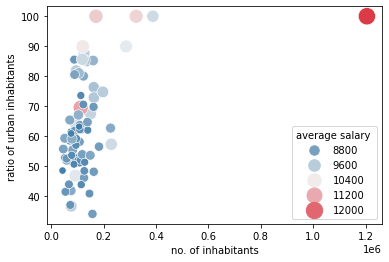

End of district processing:


district_id  region  no. of inhabitants  \
0             1       0             1204953   
1             2       1               88884   
2             3       1               75232   
3             4       1              149893   
4             5       1               95616   
..          ...     ...                 ...   
72           73       4              182027   
73           74       4              323870   
74           75       4              138032   
75           76       4              127369   
76           77       4              148545   

    no. of municipalities with inhabitants < 499   \
0                                               0   
1                                              80   
2                                              55   
3                                              63   
4                                              65   
..                                            ...   
72                                             17   
73                                              0   
74                                             67   
75                                             31   
76                                              8   

    no. of municipalities with inhabitants 500-1999  \
0                                                 0   
1                                                26   
2                                                26   
3                                                29   
4                                                30   
..                                              ...   
72                                               49   
73                                                0   
74                                               30   
75                                               32   
76                                               35   

    no. of municipalities with inhabitants 2000-9999   \
0                                                   0   
1                                                   6   
2                                                   4   
3                                                   6   
4                                                   4   
..                                                ...   
72                                                 12   
73                                                  0   
74                                                  4   
75                                                 13   
76                                                 12   

    no. of municipalities with inhabitants >10000   no. of cities   \
0                                                1               1   
1                                                2               5   
2                                                1               5   
3                                                2               6   
4                                                1               6   
..                                             ...             ...   
72                                               2               7   
73                                               1               1   
74                                               2               5   
75                                               2               7   
76                                               3               4   

    ratio of urban inhabitants   average salary   ratio entrepeneurs  \
0                         1.000            12541               0.167   
1                         0.467             8507               0.132   
2                         0.417             8980               0.111   
3                         0.674             9753               0.109   
4                         0.514             9307               0.118   
..                          ...              ...                 ...   
72                        0.564             8746               0.090   
73                        1.000        

In [20]:
def process_district(district_df):
   
    # missing_values(district_df)
    copy_district = district_df.copy()
        
    #print('District Features Financial Relation')
    #bubble_plot_three_cols(copy_district, 'no. of inhabitants', 'ratio of urban inhabitants ', 'average salary ')
    
    # Encode categoricals
    df = encode_column(copy_district, 'name ')
    df = encode_column(df, 'region')
    
    df.loc[df['no. of commited crimes \'95 ']=="?", 'no. of commited crimes \'95 '] = pd.to_numeric( df[df['no. of commited crimes \'95 '] != '?']['no. of commited crimes \'95 '] ).median()
    median_unemploymant_95 = (df[df['unemploymant rate \'95 '] != '?']['unemploymant rate \'95 ']).astype(float).median()
    df.loc[df['unemploymant rate \'95 ']=="?", 'unemploymant rate \'95 '] = median_unemploymant_95
    
    df['unemploymant rate \'95 ']      = df['unemploymant rate \'95 '].astype(float)
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 ']      = df['unemploymant rate \'96 '].astype(float)
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])
    df['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(df['no. of enterpreneurs per 1000 inhabitants '])
    df['ratio of urban inhabitants ']  = df['ratio of urban inhabitants '].astype(float)
    df['ratio entrepeneurs']           = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants ']  = df['ratio of urban inhabitants '] / 100
    df['crime_delta']                  = (df['no. of commited crimes \'96 '] - df['no. of commited crimes \'95 ']) / df['no. of inhabitants']
    df['unemploymant_delta']           = df['unemploymant rate \'96 '] - df['unemploymant rate \'95 ']
    
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants ', 'unemploymant rate \'96 ', 'no. of commited crimes \'96 ','unemploymant rate \'95 ', 'no. of commited crimes \'95 '], axis=1)
    df = df.rename(columns={'code ': 'district_id'}).drop(['name '], axis=1)

    print('End of district processing:')
    display(df)
    #print('correlation matrix:')
    #get_df_correlation(df)

    return df

processed_district = process_district(district_df)

# Pre process and merge tables

No past history regarding loans.
There is an obvious and expected correlation between the duration, amount and payments columns.


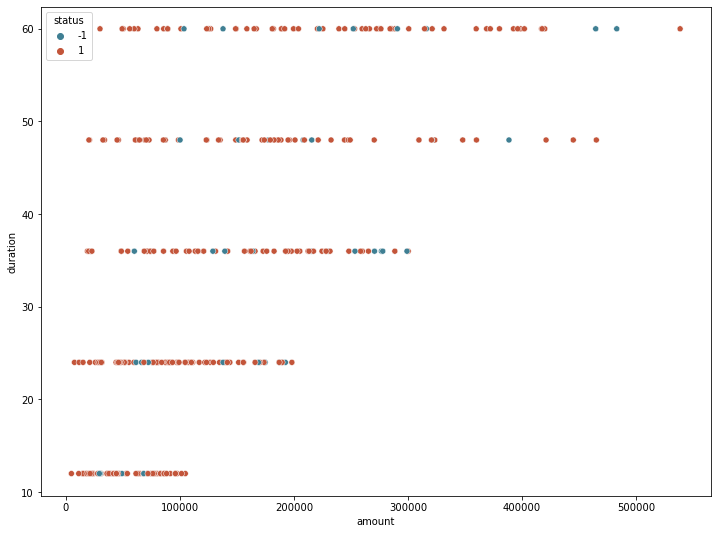

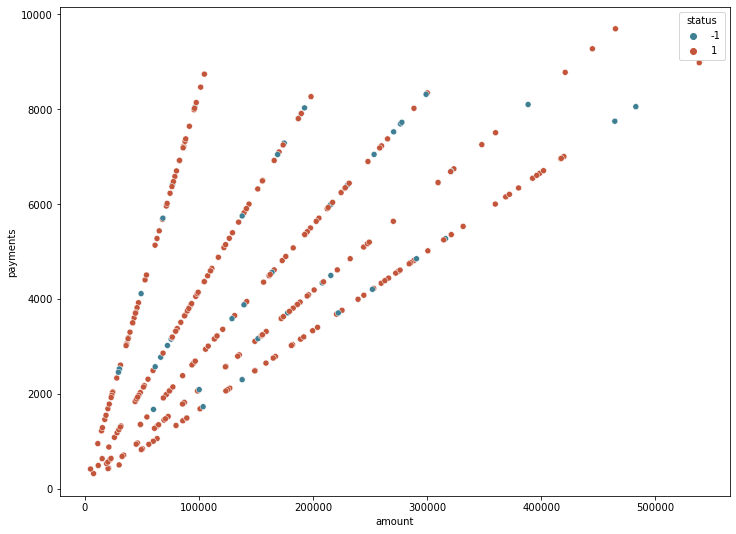

As expected, the larger the amount, the larger is the monthly payment or the duration.
Does the bank charge any interest rate?


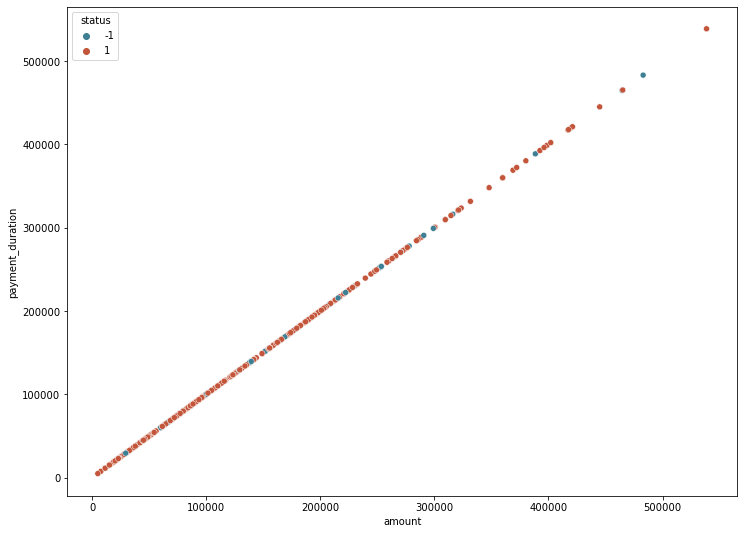

amount = columns * payments. Therefore, we can conclude that the bank does not charge any interest rate on the loan
At end of process_transactions:


account_id  balance_mean  balance_max  balance_min   balance_std  \
0              1  17558.700000      30414.8       1000.0   4168.729384   
1              2  32590.624074      67529.6       1100.0  12061.705682   
2              4  23648.623077      30623.5        800.0   5779.862046   
3              6  30313.279839      40391.5        900.0   5582.676041   
4              7  23088.850000      34875.0        900.0  15114.749329   
...          ...           ...          ...          ...           ...   
3365       11333  36827.658173     137043.2      -1291.0  29925.328077   
3366       11349  59352.833333     104039.9        200.0  27879.396857   
3367       11359  36480.185034      81705.8       1000.0  15469.988113   
3368       11362  30869.781308      56055.6       1000.0  11709.142375   
3369       11382  34805.087879      93550.2      -1036.7  21579.579905   

      last_balance  first_balance last_trans_date  last_trans  \
0          12659.9         1000.0      1996-12-31       -14.6   
1          27840.6         1100.0      1993-12-31       -14.6   
2          24943.0          800.0      1996-12-31       -14.6   
3          33509.2          900.0      1996-12-31       -14.6   
4          28305.4          900.0      1996-12-31        30.4   
...            ...            ...             ...         ...   
3365       19790.4          500.0      1996-12-31       142.8   
3366       24704.4          200.0      1995-10-23       300.0   
3367       25682.6         1000.0      1996-07-31       -14.6   
3368       24199.5         1000.0      1996-12-10     -4780.0   
3369       27005.4          200.0      1996-12-31       -14.6   

      reached_negative_balance   credit_mean  credit_count  credit_max  \
0                          1.0   1992.602000            50     12600.0   
1                          1.0  10394.786364            22     30354.0   
2                          1.0   3348.264706            17      5553.0   
3                          1.0   3603.666667            51      6669.0   
4                          1.0  11635.133333             3     33975.0   
...                        ...           ...           ...         ...   
3365                      -1.0   8962.814851           101     48037.0   
3366                       1.0  21108.227273            11     62982.0   
3367                       1.0  14509.608889            45     40521.0   
3368                       1.0   8811.758621            29     24212.0   
3369                      -1.0  11086.665306            49     46248.0   

      credit_min    credit_std  withdrawal_mean  withdrawal_count  \
0           19.2   2298.080022     -1380.479365              63.0   
1           13.5  11457.269613     -6276.393750              32.0   
2           66.6   2721.128176     -1453.527273              22.0   
3           70.3   3285.410780     -2058.600000              73.0   
4           30.4  19351.777258     -6600.000000               1.0   
...          ...           ...              ...               ...   
3365         1.1  13536.154328     -8275.402804             107.0   
3366        39.0  24734.340292    -29640.857143               7.0   
3367        67.3  15248.890444     -6149.507843             102.0   
3368        50.1   9224.068085     -2965.915385              78.0   
3369        36.3  16299.472136    -10324.820000              50.0   

      withdrawal_max  withdrawal_min  withdrawal_std  household  pension  \
0              -14.6         -7500.0     1463.225675    -2452.0      0.0   
1              -14.6        -22400.0     6011.475327    -7266.0      0.0   
2              -14.6         -4100.0     1147.934693    -2078.0   5553.0   
3              -14.6        -11600.0     2064.857715    -3954.0   6669.0   
4            -6600.0         -6600.0        0.000000        0.0      0.0   
...              ...             ...             ...        ...      ...   
3365            -0.1        -45300.0    10289.015899        0.0      0.0   
3366      

Transformed the categorical type column into numerical respective columns


disp_id  client_id  account_id  type_O  type_U
0           1          1           1       1       0
1           2          2           2       1       0
2           3          3           2       0       1
3           4          4           3       1       0
4           5          5           3       0       1
...       ...        ...         ...     ...     ...
5364    13647      13955       11349       1       0
5365    13648      13956       11349       0       1
5366    13660      13968       11359       1       0
5367    13663      13971       11362       1       0
5368    13690      13998       11382       1       0

[5369 rows x 5 columns]

2 categories are dependent. Therefore, remove one - removing redundancy


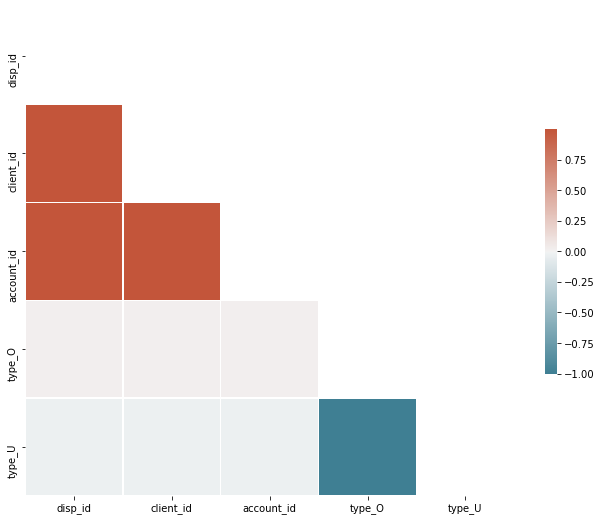

District Features Financial Relation


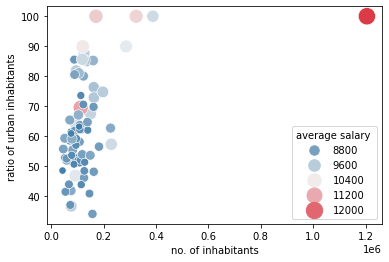

End of district processing:


district_id  region  no. of inhabitants  \
0             1       0             1204953   
1             2       1               88884   
2             3       1               75232   
3             4       1              149893   
4             5       1               95616   
..          ...     ...                 ...   
72           73       4              182027   
73           74       4              323870   
74           75       4              138032   
75           76       4              127369   
76           77       4              148545   

    no. of municipalities with inhabitants < 499   \
0                                               0   
1                                              80   
2                                              55   
3                                              63   
4                                              65   
..                                            ...   
72                                             17   
73                                              0   
74                                             67   
75                                             31   
76                                              8   

    no. of municipalities with inhabitants 500-1999  \
0                                                 0   
1                                                26   
2                                                26   
3                                                29   
4                                                30   
..                                              ...   
72                                               49   
73                                                0   
74                                               30   
75                                               32   
76                                               35   

    no. of municipalities with inhabitants 2000-9999   \
0                                                   0   
1                                                   6   
2                                                   4   
3                                                   6   
4                                                   4   
..                                                ...   
72                                                 12   
73                                                  0   
74                                                  4   
75                                                 13   
76                                                 12   

    no. of municipalities with inhabitants >10000   no. of cities   \
0                                                1               1   
1                                                2               5   
2                                                1               5   
3                                                2               6   
4                                                1               6   
..                                             ...             ...   
72                                               2               7   
73                                               1               1   
74                                               2               5   
75                                               2               7   
76                                               3               4   

    ratio of urban inhabitants   average salary   ratio entrepeneurs  \
0                         1.000            12541               0.167   
1                         0.467             8507               0.132   
2                         0.417             8980               0.111   
3                         0.674             9753               0.109   
4                         0.514             9307               0.118   
..                          ...              ...                 ...   
72                        0.564             8746               0.090   
73                        1.000        

Correlations with label:


loan_id    amount  duration  payments  frequency  balance_mean  \
status  0.121917 -0.128237 -0.003537 -0.168436  -0.007298      0.193985   

        balance_max  balance_min  balance_std  last_balance  first_balance  \
status     0.019865     0.226679    -0.083467      0.138842      -0.020962   

        last_trans  reached_negative_balance  credit_mean  credit_count  \
status   -0.097729                  0.502993     0.126995      0.019421   

        credit_max  credit_min  credit_std  withdrawal_mean  withdrawal_count  \
status    0.004996   -0.087856    0.058619         0.024413          0.122053   

        withdrawal_max  withdrawal_min  withdrawal_std  unknown_mean  \
status        0.110761       -0.005278        0.003361     -0.000019   

        unknown_sum  unknown_count  unknown_std  payment_statement_mean  \
status     0.203096       0.094239     0.025466                 -0.0139   

        payment_statement_sum  payment_statement_count  ins_payment_mean  \
status               0.043572                 0.064005         -0.084695   

        ins_payment_sum  ins_payment_count  sanctions_mean  sanctions_sum  \
status        -0.069294           0.079072        0.314902       0.286268   

        sanctions_count  sanctions_std  credit_cash  credit_cash_mean  \
status        -0.274294       -0.24354    -0.051181         -0.125393   

        credit_cash_sum  credit_cash_max  credit_cash_std  credit_cash_min  \
status         -0.03891        -0.179912        -0.204384        -0.043192   

        col_another_bank  col_another_bank_mean  col_another_bank_sum  \
status          0.137795               0.162357              0.158309   

        col_another_bank_max  col_another_bank_std  col_another_bank_min  \
status              0.160894              0.153084              0.162646   

        interest  interest_mean  interest_sum  interest_max  interest_std  \
status  0.003842        0.22164      0.101174       0.08506     -0.025943   

        interest_min  withd_cash  withd_cash_mean  withd_cash_sum  \
status      0.177928    0.058313         0.008803       -0.044506   

        withd_cash_max  withd_cash_std  withd_cash_min  rem_another_bank  \
status        0.109771         0.02563       -0.005278          0.182415   

        rem_another_bank_mean  rem_another_bank_sum  rem_another_bank_max  \
status              -0.264412             -0.203213             -0.254507   

        rem_another_bank_std  rem_another_bank_min  credit_card_withd  \
status              0.025839             -0.257403           0.048169   

        credit_card_withd_mean  credit_card_withd_sum  credit_card_withd_max  \
status               -0.057676              -0.049027              -0.049331   

        credit_card_withd_std  credit_card_withd_min  total_ops  \
status               0.044266              -0.057826   0.091208   

        last_first_balance_ratio  last_max_balance_ratio  mean_trans_profit  \
status                  0.044261                0.104247           0.185935   

        balance_range  credit_ratio  withdrawal_ratio  ratio_credit_cash  \
status       0.012576     -0.217682          0.217682          -0.204533   

        ratio_col_another_bank  ratio_withd_cash  ratio_rem_another_bank  \
status                0.115595          0.036317                0.237998   

        ratio_credit_card_withd  ratio_interest  owner_count  disponent_count  \
status                 0.043068       -0.145612       0.2199           0.2199   

        owner_gender  card_type  has_card    region  no. of inhabitants  \
status     -0.022487   0.067839  0.038804 -0.057627           -0.007891   

        no. of municipalities with inhabitants < 499   \
status                                       0.074296   

        no. of municipalities with inhabitants 500-1999  \
status                                         0.035389   

        no. of municipalities with inhabitants 2000-9999   \
status                                           0.029973   

Result of feature selection:


['payments',
 'balance_mean',
 'balance_min',
 'reached_negative_balance',
 'unknown_sum',
 'sanctions_mean',
 'sanctions_sum',
 'sanctions_count',
 'sanctions_std',
 'credit_cash_max',
 'credit_cash_std',
 'col_another_bank_mean',
 'col_another_bank_sum',
 'col_another_bank_max',
 'col_another_bank_std',
 'col_another_bank_min',
 'interest_mean',
 'interest_min',
 'rem_another_bank',
 'rem_another_bank_mean',
 'rem_another_bank_sum',
 'rem_another_bank_max',
 'rem_another_bank_min',
 'mean_trans_profit',
 'credit_ratio',
 'withdrawal_ratio',
 'ratio_credit_cash',
 'ratio_rem_another_bank',
 'owner_count',
 'disponent_count',
 'salary_mth_calc',
 'real_mth_income',
 'ratio_withd_credit_mth',
 'real_income_to_payments_ratio',
 'log_sanctions_std']

loan_id  payments  balance_mean  balance_min  reached_negative_balance  \
0       5314      8033  12250.000000       1100.0                       1.0   
1       5316      4610  52083.859459        700.0                       1.0   
2       6863      2118  30060.954167        800.0                       1.0   
3       5325      2939  41297.480000       1000.0                       1.0   
4       7240      4579  57188.211111        600.0                       1.0   
..       ...       ...           ...          ...                       ...   
323     6818      3242  44197.509884        200.0                       1.0   
324     5625      3703  55230.444068        800.0                       1.0   
325     6805       938  41994.907692        800.0                       1.0   
326     7233      3217  56646.516129       1100.0                       1.0   
327     7308      5392  30869.781308       1000.0                       1.0   

     unknown_sum  sanctions_mean  sanctions_sum  sanctions_count  \
0        20100.0             0.0            0.0              0.0   
1        62612.0             0.0            0.0              0.0   
2        27534.0             0.0            0.0              0.0   
3        47508.0             0.0            0.0              0.0   
4        40788.0             0.0            0.0              0.0   
..           ...             ...            ...              ...   
323     101122.0             0.0            0.0              0.0   
324      56990.0             0.0            0.0              0.0   
325      51200.0             0.0            0.0              0.0   
326      38211.0             0.0            0.0              0.0   
327      73977.0             0.0            0.0              0.0   

     sanctions_std  credit_cash_max  credit_cash_std  col_another_bank_mean  \
0              0.0           9900.0      3774.806838               0.000000   
1              0.0          36574.0     13044.711945               0.000000   
2              0.0           3700.0      2050.609665           13981.000000   
3              0.0           3900.0      2050.609665           19101.333333   
4              0.0            600.0         0.000000           45764.333333   
..             ...              ...              ...                    ...   
323            0.0          26388.0      6517.394689               0.000000   
324            0.0          44352.0     13832.527973               0.000000   
325            0.0          31636.5      9517.351233               0.000000   
326            0.0          49887.0     14644.196076               0.000000   
327            0.0          24212.0      6318.812124               0.000000   

     col_another_bank_sum  col_another_bank_max  col_another_bank_std  \
0                     0.0                   0.0              0.000000   
1                     0.0                   0.0              0.000000   
2                 69905.0               19065.0           2842.042399   
3                114608.0               26448.0           3599.116929   
4                274586.0               63366.0           8623.020391   
..                    ...                   ...                   ...   
323                   0.0                   0.0              0.000000   
324                   0.0                   0.0              0.000000   
325                   0.0                   0.0              0.000000   
326                   0.0                   0.0              0.000000   
327                   0.0                   0.0              0.000000   

     col_another_bank_min  interest_mean  interest_min  rem_another_bank  \
0                     0.0       0.000000           0.0               0.0   
1                     0.0     168.540000           2.9               8.0   
2                 12710.0      92.625000          48.6               3.0   
3                 17632.0     160.360000         132.8               2.0   
4                 42244.0     190

Correlation matrix (triangle)


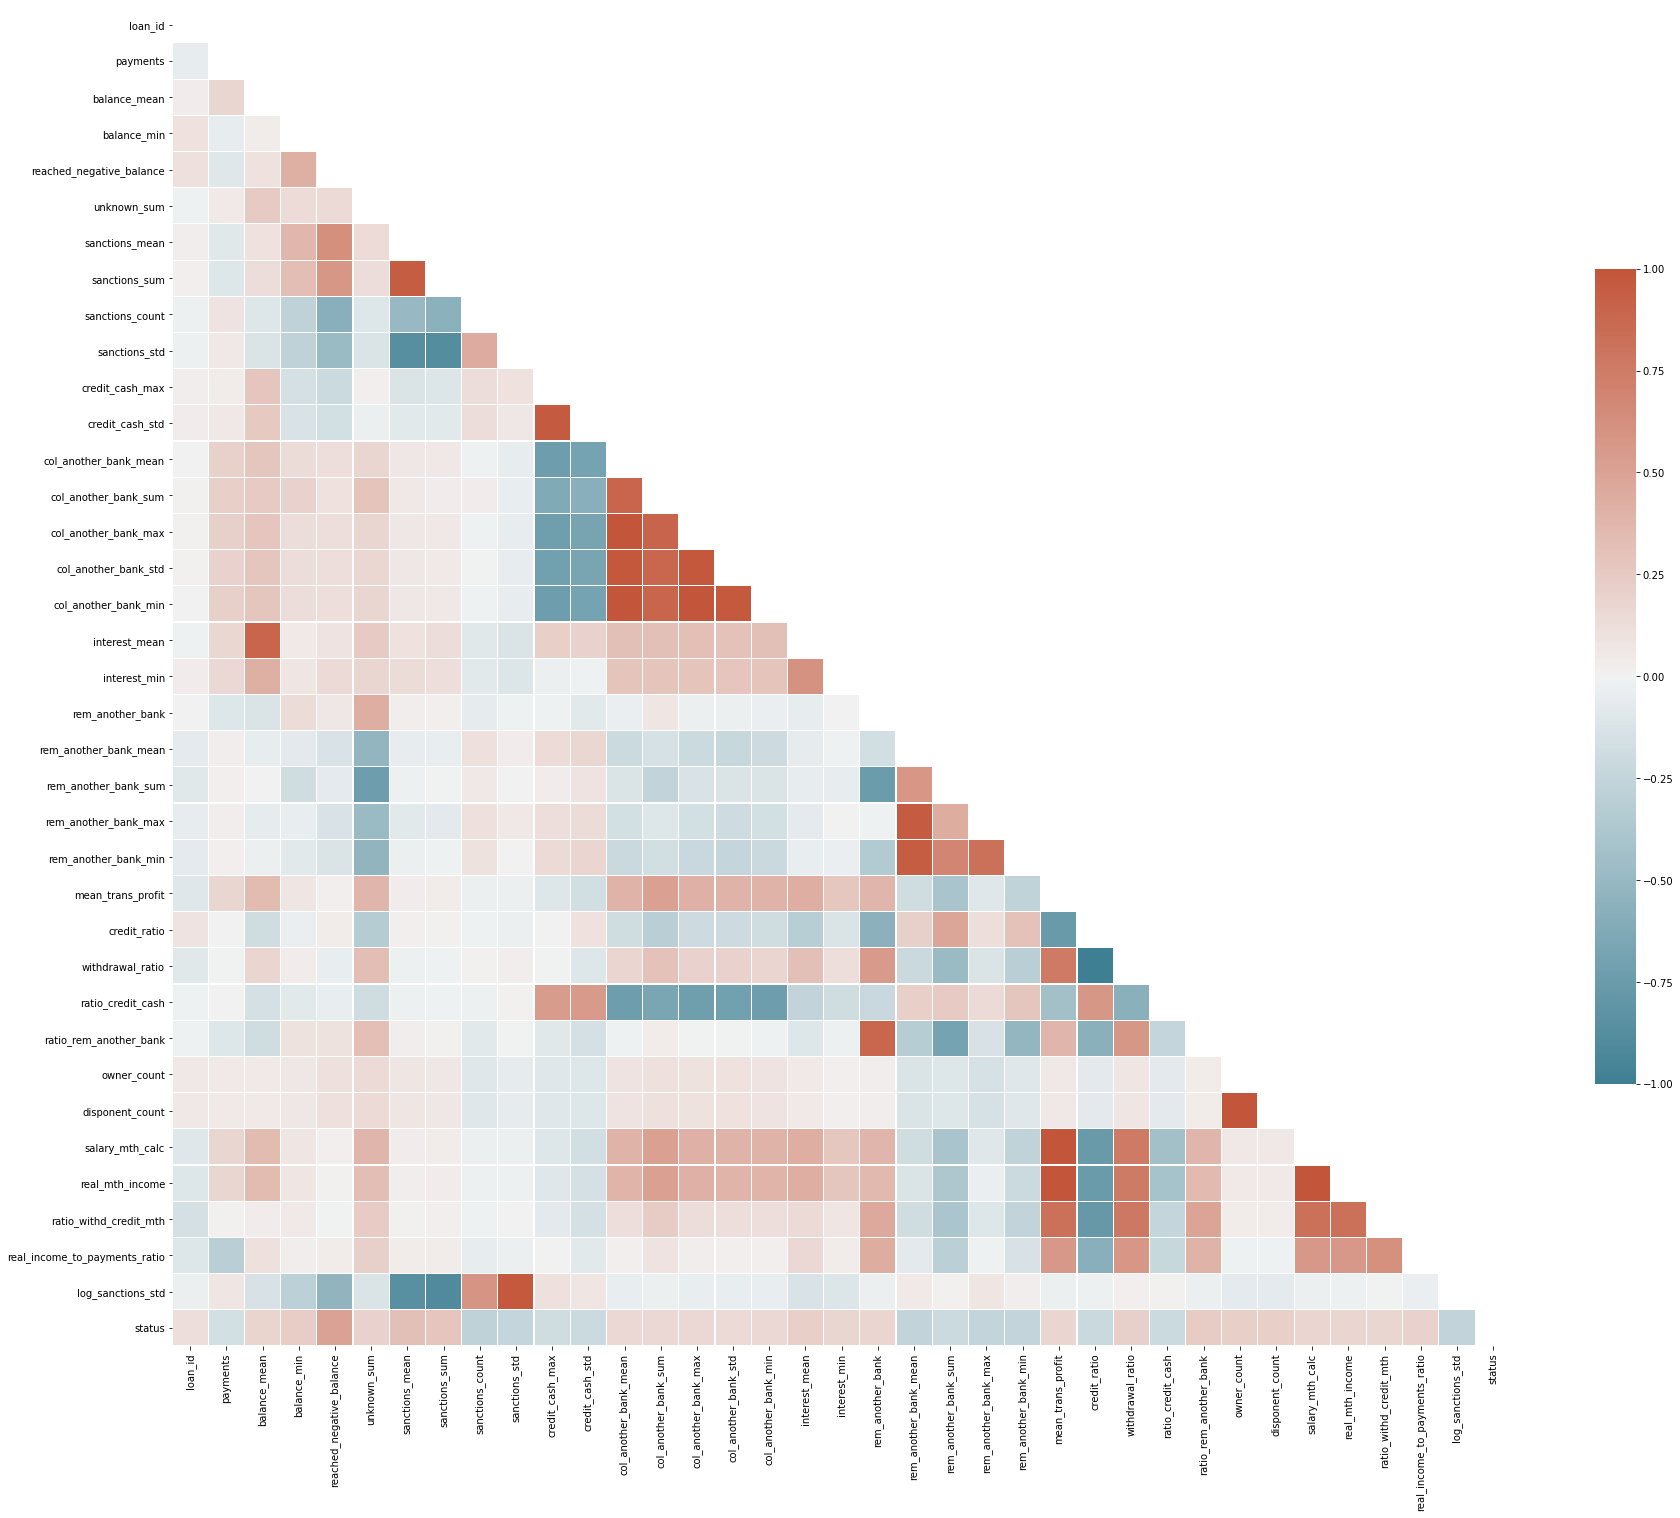

loan_id  payments  balance_mean  balance_min  reached_negative_balance  \
0       5314      8033  12250.000000       1100.0                       1.0   
1       5316      4610  52083.859459        700.0                       1.0   
2       6863      2118  30060.954167        800.0                       1.0   
3       5325      2939  41297.480000       1000.0                       1.0   
4       7240      4579  57188.211111        600.0                       1.0   
..       ...       ...           ...          ...                       ...   
323     6818      3242  44197.509884        200.0                       1.0   
324     5625      3703  55230.444068        800.0                       1.0   
325     6805       938  41994.907692        800.0                       1.0   
326     7233      3217  56646.516129       1100.0                       1.0   
327     7308      5392  30869.781308       1000.0                       1.0   

     unknown_sum  sanctions_mean  sanctions_sum  sanctions_count  \
0        20100.0             0.0            0.0              0.0   
1        62612.0             0.0            0.0              0.0   
2        27534.0             0.0            0.0              0.0   
3        47508.0             0.0            0.0              0.0   
4        40788.0             0.0            0.0              0.0   
..           ...             ...            ...              ...   
323     101122.0             0.0            0.0              0.0   
324      56990.0             0.0            0.0              0.0   
325      51200.0             0.0            0.0              0.0   
326      38211.0             0.0            0.0              0.0   
327      73977.0             0.0            0.0              0.0   

     sanctions_std  credit_cash_max  credit_cash_std  col_another_bank_mean  \
0              0.0           9900.0      3774.806838               0.000000   
1              0.0          36574.0     13044.711945               0.000000   
2              0.0           3700.0      2050.609665           13981.000000   
3              0.0           3900.0      2050.609665           19101.333333   
4              0.0            600.0         0.000000           45764.333333   
..             ...              ...              ...                    ...   
323            0.0          26388.0      6517.394689               0.000000   
324            0.0          44352.0     13832.527973               0.000000   
325            0.0          31636.5      9517.351233               0.000000   
326            0.0          49887.0     14644.196076               0.000000   
327            0.0          24212.0      6318.812124               0.000000   

     col_another_bank_sum  col_another_bank_max  col_another_bank_std  \
0                     0.0                   0.0              0.000000   
1                     0.0                   0.0              0.000000   
2                 69905.0               19065.0           2842.042399   
3                114608.0               26448.0           3599.116929   
4                274586.0               63366.0           8623.020391   
..                    ...                   ...                   ...   
323                   0.0                   0.0              0.000000   
324                   0.0                   0.0              0.000000   
325                   0.0                   0.0              0.000000   
326                   0.0                   0.0              0.000000   
327                   0.0                   0.0              0.000000   

     col_another_bank_min  interest_mean  interest_min  rem_another_bank  \
0                     0.0       0.000000           0.0               0.0   
1                     0.0     168.540000           2.9               8.0   
2                 12710.0      92.625000          48.6               3.0   
3                 17632.0     160.360000         132.8               2.0   
4                 42244.0     190

In [21]:
def complete_join(loan_df, account_df, disp_df, card_df, client_df, trans_df, district_df):

    # Pre process all tables
    loan = process_loans(loan_df)
    account = process_account(account_df)
    trans = process_transactions(trans_df)
    disp = process_disp(disp_df)
    client = process_client(client_df)
    card = process_card(card_df)
    district = process_district(district_df)
    
    # Join tables
    main_df = loan.merge(account.rename(columns={'date': 'acc_create_date'}), on='account_id', how='left').merge(trans, on='account_id', how='left')
    main_df = main_df.drop(['district_id'], axis=1)    
    # display(main_df)

    df_disp_client_card = disp.merge(client, on='client_id', how='left').merge(card, on='disp_id', how='left')

    # display(df_disp_client_card)
    # missing_values(df_disp_client_card)
    
    # Drop card issue date (almost unique values)
    df_disp_client = df_disp_client_card.drop(['issued'], axis=1)
    df_disp_client = clean_numerical_missing_values(df_disp_client, -1)
    
    # print(df_disp_client.dtypes)
    # display(df_disp_client)

    # Now we aggreggate the remaining data
    df_disp_client = df_disp_client.sort_values(by=['account_id', 'type_O'], ascending=[True, False]).groupby(['account_id']).agg({'type_O': ['count'],'type_U': ['count'],'gender': get_first,'birth_date': get_first,'district_id': get_first,'type': get_first}).reset_index()
    df_disp_client.columns= ['account_id', 'owner_count', 'disponent_count', 'owner_gender', 'owner_birthdate', 'district_id', 'card_type']
    df_disp_client['has_card'] = df_disp_client['card_type']
    df_disp_client.loc[df_disp_client["card_type"] > 0, "has_card"] = 1
    df_disp_client.loc[df_disp_client["card_type"] == 0, "has_card"] = -1
    # display(df_disp_client)
    
    # Final Join
    df = main_df.merge(df_disp_client.merge(district, on='district_id'), on='account_id')
    
    
    # 'Ratios' - resulting from operations that combine columns
    df['acc_age_on_loan']                        = (df['date']             - df['acc_create_date']).dt.days    
    df['acc_age_mths']                           = df['acc_age_on_loan']   / 30
    
    # monthly features
    df["trans_mth"]                              = df['total_ops']         / df["acc_age_mths"]
    df['withdrawal_mth']                         = df['withdrawal_mean']   / df["acc_age_mths"]
    df['credit_mth']                             = df['credit_mean']       / df["acc_age_mths"]
    df['avg_mth_income']                         =  (df['average salary '] + df['household'])               / 12
    df['salary_mth_calc']                        = df['credit_mean']       + df['withdrawal_mean']
    df['real_mth_income']                        =  df['salary_mth_calc']  + (df['household']               / 12)
    df.loc[df["pension"] > 0, "avg_mth_income"]  = (df["pension"]          + df['household'])               / 12
    df.loc[df["pension"] > 0, "real_mth_income"] = df["real_mth_income"]   + (df['pension']                 / 12)
    
    df['ratio_real_salary_to_expected']          = df['real_mth_income']   / df['avg_mth_income']
    df['ratio_withd_credit_mth']                 = df['withdrawal_mth']    / df['credit_mth']
    
    df['last_transaction_days']                  = (df['date']             - df['last_trans_date']).dt.days
    df['owner_age_on_loan']                      = (df['date']             - df['owner_birthdate']).dt.days / 365
    
    df["ratio_max_value_in_account_to_loan"]     = df["balance_max"]       / df["amount"]
    df["ratio_last_value_in_account_to_loan"]    = df["last_balance"]      / df["amount"]
    df['ratio_expected_income_to_payments']      = df['avg_mth_income']    / df['payments']
    df['real_income_to_payments_ratio']          = df['real_mth_income']   / df['payments']

    # log transformation applied to reduce skewness, approximating to a normal distribution
    df['log_credit_min']                         = df['credit_min'].transform(np.log1p)
    df['log_crime_delta']                        = df['crime_delta'].transform(np.log1p)
    df['log_sanctions_std']                      = df['sanctions_std'].transform(np.log1p)
    df['log_col_another_bank_sum']               = df['col_another_bank_sum'].transform(np.log1p)
    df['log_col_another_bank_mean']              = df['col_another_bank_mean'].transform(np.log1p)
    df['log_ratio_max_value_in_acc_to_loan']     = df['ratio_max_value_in_account_to_loan'].transform(np.log1p)

    
    # print('Age at time of loan (years)')
    # column_density_plot(df, 'owner_age_on_loan')
    
    df = df.drop(['district_id', 'account_id', 'owner_birthdate', 'pension', 'household', 'acc_create_date', 'last_trans_date'], axis=1)

    # display(df)
    
    # status as last col
    df =  df[ [col for col in df if col not in ['status'] ] + ['status'] ]
    
    # Features selection
    select_features_filtering(df)
    #select_features_wrapper(df)
    
    print('Result of feature selection:')
    display(filter_features)
        
    df = df[['loan_id'] + filter_features + ['status']]
    #df = df[['loan_id'] + wrapper_features + ['status']]
    
    #df = df[['loan_id'] + ['amount','duration', 'payments', 'frequency', 'balance_mean', 'balance_max', 'balance_min', 'balance_std', 'last_balance', 'last_trans', 'reached_negative_balance', 'credit_mean', 'credit_count', 'credit_max', 'credit_min', 'withdrawal_mean', 'withdrawal_count', 'withdrawal_max', 'withdrawal_min', 'withdrawal_std', 'unknown_mean', 'unknown_sum', 'unknown_std', 'payment_statement_sum', 'payment_statement_count', 'ins_payment_mean', 'ins_payment_sum', 'ins_payment_count', 'sanctions_mean', 'sanctions_sum', 'sanctions_count', 'sanctions_std', 'credit_cash', 'credit_cash_mean', 'credit_cash_max', 'credit_cash_std', 'credit_cash_min', 'CAB', 'CAB_mean', 'CAB_min', 'interest', 'interest_mean', 'interest_sum', 'interest_max', 'interest_std', 'interest_min', 'withd_cash', 'withd_cash_mean', 'withd_cash_max', 'rem_another_bank', 'rem_another_bank_mean', 'rem_another_bank_sum', 'rem_another_bank_max', 'rem_another_bank_std', 'credit_card_withd', 'credit_card_withd_mean', 'credit_card_withd_sum', 'credit_card_withd_max', 'credit_card_withd_std', 'credit_card_withd_min', 'mean_trans_profit', 'total_ops', 'credit_ratio', 'withdrawal_ratio', 'last_max_balance_ratio', 'ratio_credit_cash', 'ratio_withd_cash', 'ratio_rem_another_bank', 'ratio_credit_card_withd', 'ratio_interest', 'owner_count', 'owner_gender', 'card_type', 'has_card', 'region', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ', 'no. of municipalities with inhabitants >10000 ', 'ratio of urban inhabitants ', 'average salary ', 'ratio entrepeneurs', 'crime_delta', 'last_transaction_days', 'owner_age_on_loan', 'ratio_max_value_in_account_to_loan', 'acc_age_mths', 'withdrawal_per_mth', 'salary_mth_calc', 'avg_mth_income', 'real_mth_income', 'ratio_expected_income_to_payments', 'log_credit_min', 'log_sanctions_std', 'log_CAB_mean', 'log_ratio_max_value_in_acc_to_loan'] + ['status']]
    
    display(df)
    print('Correlation matrix (triangle)')
    get_df_correlation(df, (30, 30))

    return df

        
tables_joined = complete_join(loan_df, account_df, disp_df, card_df, client_df, trans_df, district_df)
display(tables_joined)

In [22]:
def write_df_to_csv(df, dir_, filename):
    csv = df.to_csv(index = False)
    os.makedirs(dir_, exist_ok=True)
    path = "{}/{}".format(dir_, filename)

    with open(path, 'w') as fd: fd.write(csv)


#tables_joined = process_transactions(trans_df, True)
#write_df_to_csv(tables_joined, 'dataset', 'preprocessed_transactions.csv')

# Outputting the resultant table to a final csv
#write_df_to_csv(tables_joined, 'dataset', 'preprocessed_data_3.csv')

#test_tables_joined = complete_join(loan_test_df, account_df, disp_df, card_test_df, client_df, trans_test_df, district_df)
#write_df_to_csv(test_tables_joined, 'dataset', 'test_dataset_3.csv')